### ASTR-598, Winter 2018, Connolly & Ivezic, University of Washington
https://github.com/dirac-institute/uw-astr598-w18/tree/master/lectures/Week-5-Tue.ipynb


# Week 5, Tuesday: Model Parameter Estimation and Model Selection in Bayesian Framework




##### Resources for this notebook include:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.  
- [Gordon Richard's notebooks](https://github.com/gtrichards/PHYS_T480)
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Highly recommended supplemental background reading:

- [Jake VanderPlas: ``Frequentism and Bayesianism: A Python-driven Primer"](https://arxiv.org/abs/1411.5018)
- [Hogg, Bovy and Lang: ``Data analysis recipes: Fitting a model to data"](https://arxiv.org/abs/1008.4686)


##### For those who want to dive deep:

- [D. Sivia and J. Skilling: ``Data Analysis: A Bayesian Tutorial''](https://www.amazon.com/Data-Analysis-Bayesian-Devinderjit-Sivia/dp/0198568320)
- [E.T. Jaynes: ``Probability Theory: The Logic of Science''](http://bayes.wustl.edu/etj/prob/book.pdf)
- [E.T. Jaynes: ``Confidence Intervals vs. Bayesian intervals''](http://bayes.wustl.edu/etj/articles/confidence.pdf)

##### Topics for this week: 
- Bayesian model parameter estimation 
- Bayesian model selection 
- optimal bin width for classical histograms
- Bayesian Blocks algorithm for optimal histograms 


In [13]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
from astroML.plotting import hist
np.random.seed(42)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

![BayesSlide1](figures/bayes2.tiff)

## Bayesian Statistical Inference

In Bayesian inference, we evaluate the **posterior probability** by using
** data likelihood** and **prior** information: 
 
$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

The prior can be expanded as 
$$p(M,\theta\,|\,I) = p(\theta\,|\,M,I)\,p(M\,|\,I).$$
 
It is often the case that $p(D\,|\,I)$ is not evaluated explictly since the posterior probability 
can be (re)normalized. 

**The Bayesian Statistical Inference process** is then
* formulate the likelihood, $p(D\,|\,M,\theta,I)$
* chose a prior $p(M,\theta\,|\,I)$, which incorporates *other information beyond the data in $D$*
* determine the posterior pdf, $p(M,\theta \,|\,D,I)$
* search for the model parameters that maximize $p(M,\theta \,|\,D,I)$ 
* quantify the uncertainty of the model parameter estimates (credible region)
 
  

 
 
 

Let's now take a look at another example where adequate priors are important and influence the final result: the fitting of a straight line to (x,y) data. 

An excellent discussion of this case can be found in a 
[blog by Jake VanderPlas](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/).

A great reference in that blog is a paper by Jaynes: "Straight Line Fitting: A Bayesian Solution"

In Week 3, we covered MLE approach to fitting a straight line - let's recall what we did.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process. I.e.:

$$ y_i = a x_i + b + r_i $$

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the known homoscedastic measurement 
uncertainty for $y$ (and we assume that the uncertainty for x is negligible). 

Assuming the measurements are independent, the likelihood is the product of individual probabilities 
for every $y_i$:

$$ L(a, b) = \prod_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - a x_i - b)^2}{2 \sigma^2} \right) $$.

and $\ln L$ is equal to:

$$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - a x_i - b)^2.$$

This is the expression that the MLE minimizes with respect to $a$ and $b$ to find ML estimators for those parameters.  

In Bayesian approach we have for the posterior probability

$$ p(a, b \,|\, \{x_i,y_i\}) \propto L(a, b) \, p(a) \, p(b), $$

where $p(a)$ and $p(b)$ are priors for $a$ and $b$. Obviously, if we adopt uniform priors
the MLE values of $a$ and $b$ maximize the posterior probability, too.

** However, the uniform prior for $a$ is not an uninformative prior! **   Let's illustrate this point.

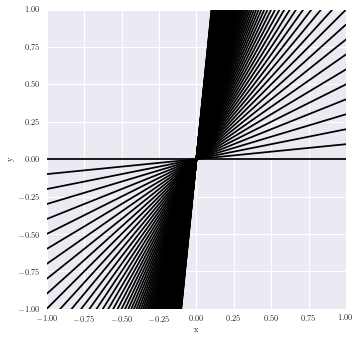

In [14]:
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
x = np.linspace(-1, 1)

for slope in np.arange(0, 10, 0.1):
    plt.plot(x, slope * x, '-k')

ax.axis([-1, 1, -1, 1], aspect='equal');
plt.xlabel('x')
plt.ylabel('y')
plt.show() 

These lines have evenly-spaced slopes in units of 0.1, yet the higher slopes 
are bunched together. Due to this bunching, a flat prior on slope will highly 
favor very steep slopes! A flat prior on slope is not a minimally informative 
prior, and may end up biasing your result for small datasets (with enough data 
the effect vanishes).

An uninformative prior for the slope can be derived by requiring symmetry 
(the same answers) between fitting y vs. x and x vs. y. The result is that

$$   p(a) \propto \frac{1}{(1 + a^2)^{3/2}}. $$

Note that $a$ is the tangent of the angle with the $x$ axis, $\theta$, $a=tan(\theta)$,
and $p(a)$ is
defined for $-\infty < a < \infty$.

We will solve this problem with uninformative and flat priors for $a$ next
week (after we introduce Markov Chain Monte Carlo method and tools). 

And one final simple Bayesian example: the coin flip. 
 

### Parameter estimation for the binomial distribution

If you flip a coin $N$ times and get $k$ tails, the probability of tails, $b$,
can be estimated as $b_o=k/N$. 
For large N, the uncertainty of $b_o$ is approximately Gaussian and given by 
$$ \sigma_b = \left[\frac{b_o \, (1-b_o)}{N}\right]^{1/2}. $$

For small N, we can use Bayesian approach to compute posterior pdf $p(b)$, as follows.

Here the data set $\{x_i\}$ is discrete: all outcomes are either 0 (heads) or 1 (tails, which we will consider “success”). An astronomical analog might be the computation of the fraction of galaxies which show evidence for a black hole in their center. 

Given a model parametrized by the probability of success (i.e. tails) $b$, the likelihood that the data set 
contains k outcomes equal to 1 is given by 
  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$

Assuming that the prior for $b$ is flat in the range 0-1, the posterior pdf for $b$ is
$$ p(b \,|\, k, N ) = C \, b^k \, (1-b)^{N-k}, $$

where the normalization constant $C$ can be determined from the condition $\int_0^1 p(b\,|\,k,N)\, db = 1$.

For a concrete numerical example, let us assume that we studied $N = 10$ galaxies and found 
a black hole in $k = 4$ of them. Our best estimate for the fraction of galaxies with black 
holes is $b_o = k/N = 0.4$. An interesting question is, “What is the probability that, say, 
$b < 0.1$?”. For example, your colleague’s theory placed *an upper limit of 10%* for the fraction 
of galaxies with black holes and you want to test this theory using classical framework 
“Can it be rejected at a confidence level $\alpha = 0.01$?”.

In other words, if the probability of $b < 0.1$, given data, is smaller than 0.01 (that is,
the probability of $b > 0.1$ is larger than 0.99) we reject the theory (in classical statistical 
hypothesis testing), and if the probability of $b < 0.1$ is larger than 0.01 we cannot reject
the theory (which does not prove that the theory is correct!). We will address Bayesian
hypothesis testing further below. 

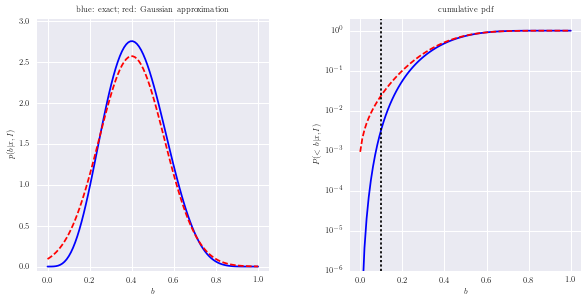

In [15]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import norm, binom
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Plot posterior as a function of b
n = 10  # number of points
k = 4  # number of successes from n draws

b = np.linspace(0, 1, 100)
db = b[1] - b[0]

# compute the probability p(b) (eqn. 5.70)
p_b = b ** k * (1 - b) ** (n - k)
p_b /= p_b.sum()
p_b /= db
cuml_p_b = p_b.cumsum()
cuml_p_b /= cuml_p_b[-1]

# compute the gaussian approximation (eqn. 5.71)
b0 = k * 1. / n
sigb = np.sqrt(b0*(1-b0)/n)
p_g = norm(b0, sigb).pdf(b)
cuml_p_g = p_g.cumsum()
cuml_p_g /= cuml_p_g[-1]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

ax = fig.add_subplot(121)
ax.plot(b, p_b, '-b')
ax.plot(b, p_g, '--r')

ax.set_ylim(-0.05, np.max(p_b)*1.1)

ax.set_xlabel('$b$')
ax.set_ylabel('$p(b|x,I)$')
plt.title('blue: exact; red: Gaussian approximation')


ax = fig.add_subplot(122, yscale='log')
ax.plot(b, cuml_p_b, '-b')
ax.plot(b, cuml_p_g, '--r')
ax.plot([0.1, 0.1], [1E-6, 2], ':k')
plt.title('cumulative pdf')


ax.set_xlabel('$b$')
ax.set_ylabel('$P(<b|x,I)$')
ax.set_ylim(1E-6, 2)

plt.show()

### Parameter estimation for the binomial distribution

For $N=10$ and $k=4$: $p(b < 0.1\,|\,k = 4, N = 10) = 0.003$ and the theory is rejected
at a confidence level $\alpha = 0.01$. 

However, using Gaussian approximation we get 
$p(b < 0.1) = 0.03$ and thus at a confidence level $\alpha = 0.01$ the theory is **not** rejected! 

**Conclusion**: when $N$ is not large, or $b_o$ is close to 0 or 1, one should avoid using the 
Gaussian approximation when estimating the credible region (or the confidence interval) for $b$.

An interesting numerical experiment is to observe how $p(b \,|\, k, N )$ evolves with the number
and outcome of coin flips - this was covered by Andy last week. 

Here, experiment with the above code by changing $k$ and $N$ and observing the bahavior of $p(b)$, and its (dis)agreement with the Gaussian approximation. 

## Bayesian Statistical Inference

In Bayesian inference, we evaluate the **posterior probability** by using
** data likelihood** and **prior** information: 
 
$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

The prior can be expanded as 
$$p(M,\theta\,|\,I) = p(\theta\,|\,M,I)\,p(M\,|\,I).$$
 
It is often the case that $p(D\,|\,I)$ is not evaluated explictly since the posterior probability 
can be (re)normalized. 

**The Bayesian Statistical Inference process** is then
* formulate the likelihood, $p(D\,|\,M,\theta,I)$
* chose a prior $p(M,\theta\,|\,I)$, which incorporates *other information beyond the data in $D$*
* determine the posterior pdf, $p(M,\theta \,|\,D,I)$
* search for the model parameters that maximize $p(M,\theta \,|\,D,I)$ 
* quantify the uncertainty of the model parameter estimates
 
 
The above procedure is valid for a given model $M$. For example, we can fit a straight
line to data $\{x_i,y_i\}$. 

**What if we have a competing model?**

For example, how do we know that we should fit a straight line to our data and not, perhaps, 
a parabola, or y=sin(x), etc? 
  

##  Markov Chain Monte Carlo with PyMC

Let's use MCMC to fit a model consisting of a burst signal added to an unknown background.

<img src="figures/book_burst.tiff" alt="Drawing" style="width: 600px;"/>

 

@pickle_results: using precomputed results from 'matchedfilt_burst.pkl'


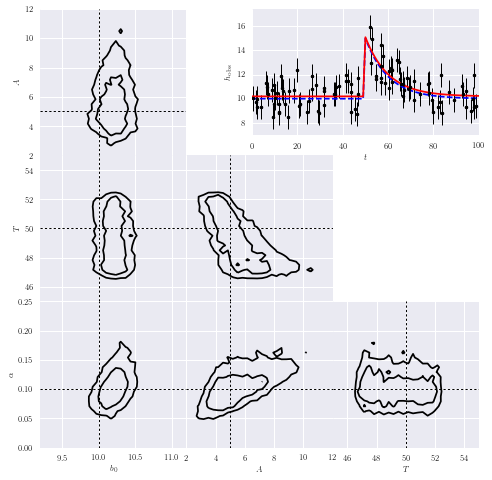

In [20]:
 ### AstroML book figure 10.25

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y

np.random.seed(0)

N = 100
b0_true = 10
A_true = 5
alpha_true = 0.1
T_true = 50
sigma = 1.0

t = 100 * np.random.random(N)

y_true = burst(t, b0_true, A_true, alpha_true, T_true)
y_obs = np.random.normal(y_true, sigma)


#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha(log_alpha=log_alpha):
    return np.exp(log_alpha)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, alpha=alpha, T=T):
    return burst(t, b0, A, alpha, T)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
             alpha=alpha, y_model=y_model, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling
@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
limits = [(9.2, 11.2), (2, 12), (45, 55), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = burst(t_fit, *fit_vals)
y_true = burst(t_fit, b0_true, A_true, alpha_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()

**It is easy to modify the code to use other profiles. Let's try a Gaussian profile! **

 [-----------------100%-----------------] 25000 of 25000 complete in 4.9 sec

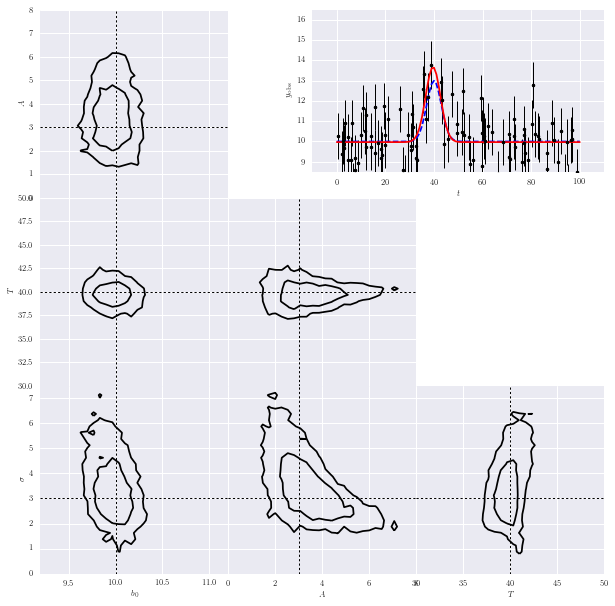

In [26]:
 ### Modeled after AstroML book figure 10.25
## burst model replaced by gaussian profile

#----------------------------------------------------------------------
# Set up toy dataset
def GaussAndBkgd(t, b0, A, sigW, T):
    """Gaussian profile + flat background model"""
    y = np.empty(t.shape)
    y.fill(b0)
    y += A * np.exp(-(t - T)**2/2/sigW**2)
    return y

np.random.seed(42)
N = 101
b0_true = 10
A_true = 3
sigma_true = 3.0
T_true = 40
err0_y = 0.5

t = 100 * np.random.random(N)
y_true = GaussAndBkgd(t, b0_true, A_true, sigma_true, T_true)
err_y = np.random.uniform(0, 2*err0_y) + 0.5*np.sqrt(y_true/10) 
y_obs = np.random.normal(y_true, err_y)

labels = ['$b_0$', '$A$', '$T$', r'$\sigma$']
limits = [(9.2, 11.2), (0, 8), (30, 50), (0.0, 7.5)]
true = [b0_true, A_true, T_true, sigma_true]

#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
log_sigma = pymc.Uniform('log_sigma', -2, 2, value=0.1)


# uniform prior on log(alpha)
@pymc.deterministic
def sigma(log_sigma=log_sigma):
    return np.exp(log_sigma)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, sigma=sigma, T=T):
    return GaussAndBkgd(t, b0, A, sigma, T)

y = pymc.Normal('y', mu=y_model, tau=err_y ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_sigma=log_sigma, sigma=sigma, y_model=y_model, y=y)

#----------------------------------------------------------------------
# Run the MCMC sampling
#@pickle_results('matchedfilt_gauss.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'sigma']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.sigma.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = GaussAndBkgd(t_fit, *fit_vals)
y_true = GaussAndBkgd(t_fit, b0_true, A_true, sigma_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, err_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.set_xlim(-10, 110)
ax.set_ylim(8.5, 16.5)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()

In [16]:
## Let's use Jake's excellent example from
## http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # set default plot styles
from scipy import stats
from scipy import optimize

# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, model=polynomial_fit, data=data):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, model, data)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

CHI2:
   best linear model: 11.3241283783
best quadratic model: 9.46283521857
    best cubic model: 8.99360837039
CHI2 per degree of freedom:
   best linear model: 0.629118243242
best quadratic model: 0.556637365798
    best cubic model: 0.562100523149


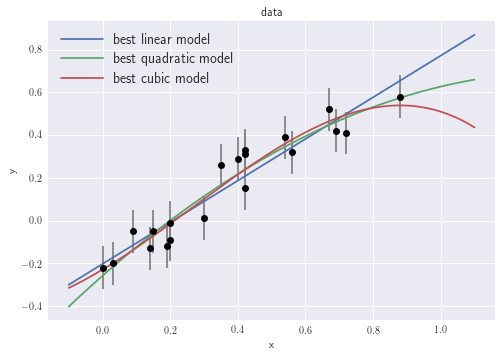

In [17]:
# generate (x,y, sigma_y) "data" 
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.22,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])
x, y, sigma_y = data
Ndata = x.size

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1)
theta2 = best_theta(2)
theta3 = best_theta(3)
# generate best fit lines on a fine grid 
xfit = np.linspace(-0.1, 1.1, 1000)
yfit1 = polynomial_fit(theta1, xfit)
yfit2 = polynomial_fit(theta2, xfit)
yfit3 = polynomial_fit(theta3, xfit)
# and compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) 
# the number of fitted parameters is 2, 3, 4
chi2dof1 = chi21/(Ndata - 2)
chi2dof2 = chi22/(Ndata - 3)
chi2dof3 = chi23/(Ndata - 4)

print "CHI2:"
print '   best linear model:', chi21
print 'best quadratic model:', chi22
print '    best cubic model:', chi23
print "CHI2 per degree of freedom:"
print '   best linear model:', chi2dof1
print 'best quadratic model:', chi2dof2
print '    best cubic model:', chi2dof3

# plot 
fig, ax = plt.subplots()
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best quadratic model')
ax.plot(xfit, polynomial_fit(theta3, xfit), label='best cubic model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');


$\chi^2$ per degree of freedom was computed as 
$$ \chi^2_{dof}  = \frac{1}{N-k} \sum_i^N \left( \frac{y - y_{fit}}{\sigma_y} \right)^2, $$
where $N$ is the number of data points and $k$ is the number of free model parameters (2, 3, and 4).

For large values of $(N-k)$ (larger than about 10), the distribution of 
$\chi^2$ per degre of freedom is approximately Gaussian centered on $\mu=1$ and the width of
$\sigma=\sqrt{2/(N-k)}$  (here, $\sigma = 0.33, 0.34, 0.35$). 

The values of $\chi^2$ per degre of freedom for the three models are: 

   best linear model: 0.629 

best quadratic model: 0.557

best cubic model: 0.562 

 
**Which model should we adopt?**

Obviously, the cubic model has the lowest $\chi2$ ("fits the best"), but 
it has 4 free parameters while the linear model has only 2 free parameters.

**How do we trade improvement in $\chi^2$ with increasing model
complexity? **

**Occam’s razor:** select the simplest model that is in fair agreement with the data.

This principle was already known to Ptolemy who said: “We consider it a good principle 
to explain the phenomena by the simplest hypothesis possible.”


### Bayesian Model Comparison

Up to now we have concerned ourselves with determining the optimal parameters of a given model fit.  But what if *another* model would be a better fit (regardless of how you choose the parameters of the first model).  

That leads us to a discussion of model comparison (see textbook $\S$5.4 and $\S$5.7.1-3).
We start with the Bayes theorem,
$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

and marginalize over model parameter space $\theta$
to obtain **the probability of model $M$** given the data $D$ and prior information $I$:

$$p(M\,|\,D,I) \equiv \int p(M,\theta \,|\,D,I) \, d\theta = 
      \int \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)} \, d\theta =
      \frac{p(M\,|\,I)}{p(D\,|\,I)} \int p(D\,|\,M,\theta,I)\,p(\theta\,|\,M,I) \, d\theta  $$
 
To determine which model is better we compute the ratio of the posterior probabilities or the **odds ratio** for two models as
$$O_{21} \equiv \frac{p(M_2|D,I)}{p(M_1|D,I)}.$$

The posterior probability that the model $M$ is correct given data $D$ (a number between 0 and 1) is
$$p(M|D,I) = \frac{p(D|M,I)p(M|I)}{p(D|I)},$$
the odds ratio can ignore $p(D|I)$ since it  will be the same for both models.  

We get 
$$O_{21} = \frac{p(D\,|\,M_2,I)\,p(M_2\,|\,I)}{p(D\,|\,M_1,I)\,p(M_1\,|\,I)} \equiv B_{21} \, \frac{p(M_2\,|\,I)}{p(M_1\,|\,I)},$$

where $B_{21}$ is called the Bayes factor. 

The Bayes factor compares how well the models fit the data: it is a ratio of data likelihoods averaged over 
all allowed values of the model parameters; if two models fit the data equally well, the "winner" is decided based on priors. 

For example, consider a noisy image of a source which is equally likely to be a star or a galaxy. 
The posterior probability that the source is a star will greatly depend on whether we are looking 
at the Galactic plane or not. 


We can compute 
$$ E(M) \equiv p(D\,|\,M, I) = \int p(D\,|\,M, \theta, I) \, p(\theta\,|\,M, I) \, d\theta, $$
where $E(M)$ is called **the marginal likelihood for model $M$** and it quantifies the probability that the 
data $D$ would be observed if the model $M$ were the correct model. 

In the physics literature, the marginal likelihood $E(M)$ is often called **evidence** (despite the fact that to 
scientists, evidence and data mean essentially the same thing). 
Since the evidence $E(M)$ involves integration of the data likelihood $p(D|M,\theta,I)$, it is also 
called **the global likelihood for model M**. The global likelihood, or evidence, is a weighted average 
of the likelihood function, with the prior for model parameters acting as the weighting function.

The following plot from the last time shows the data likelihood $p(D|M, \theta, I)$ for a sample drawn
from Gaussian distribution. 

![BayesSlide1](figures/Lcauchy.tiff)


The best $\mu$ and $\sigma$ are found as the maximum of this distribution. 
The marginal likelihood for model $M=Gauss$ is found by **integrating** this image over $\mu$ and $\sigma$.

If we think that the sample might have been drawn from some other distribution, we can produce an analogous
$p(D|M, \theta, I)$, say for $M=Cauchy$ ([here is an example](http://www.astroml.org/book_figures/chapter5/fig_likelihood_cauchy.html))
integrate it and compute the Bayes factor and the models odds
ratio (with models assigned equal prior probabilities unless there is a reason that one model is more 
likely than another, e.g. recall the star/galaxy case) 


**How do we interpret the values of the odds ratio in practice?**

Jeffreys proposed a five-step scale for 
interpreting the odds ratio, where $O_{21} > 10$ represents “strong” evidence in favor of $M_2$ ($M_2$ 
is ten times more probable than $M_1$), and $O_{21} > 100$ is “decisive” evidence ($M_2$ is one hundred 
times more probable than $M_1$). When $O_{21} < 3$, the evidence is “not worth more than a bare mention.”


### Bayesian Hypothesis Testing

In *hypothesis testing* we are essentially comparing a model, $M_1$, to its complement.  That is $p(M_1) + p(M_2) = 1$.  If we take $M_1$ to be the "null" (default) hypothesis (which is generally that, for example, a correlation does *not* exist), then we are asking whether or not the data reject the null hypothesis.

In classical hypothesis testing we can ask whether or not a single model provides a good description of the data.  

** In Bayesian hypothesis testing, we must have an alternative comparison model! **


Let's draw sample from a Cauchy distribution and perform Bayesian Model Comparison for 
Cauchy and Gaussian models. 


Results for first 10 points:
  L(M = Cauchy) = 1.18e-12 +/- 5.01e-13
  L(M = Gauss)  = 8.09e-13 +/- 4.78e-13
  O_{CG} = 1.45 +/- 0.859


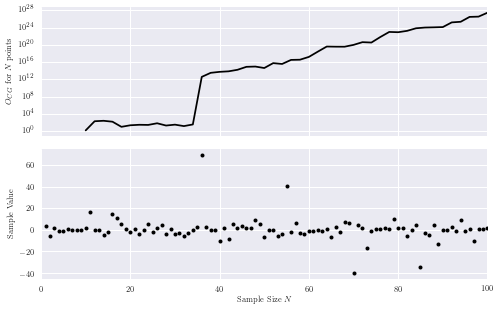

In [18]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import cauchy, norm
from scipy import integrate

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


def logL_cauchy(xi, gamma, mu,
                mu_min=-10, mu_max=10, sigma_min=0.01, sigma_max=100):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(gamma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    prior_normalization = - (np.log(mu_max - mu_min)
                             + np.log(np.log(sigma_max / sigma_min)))

    return (prior_normalization
            - n * np.log(np.pi)
            + (n - 1) * np.log(gamma)
            - np.sum(np.log(gamma ** 2 + (xi - mu) ** 2), 0))


def logL_gaussian(xi, sigma, mu,
                  mu_min=-10, mu_max=10, sigma_min=0.01, sigma_max=100):
    """Equation 5.57: gaussian likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    prior_normalization = - (np.log(mu_max - mu_min)
                             + np.log(np.log(sigma_max / sigma_min)))

    return (prior_normalization
            - 0.5 * n * np.log(2 * np.pi)
            - (n + 1) * np.log(sigma)
            - np.sum(0.5 * ((xi - mu) / sigma) ** 2, 0))


def calculate_odds_ratio(xi, epsrel=1E-8, epsabs=1E-15):
    """
    Compute the odds ratio by perfoming a double integral
    over the likelihood space.
    """
    gauss_Ifunc = lambda mu, sigma: np.exp(logL_gaussian(xi, mu, sigma))
    cauchy_Ifunc = lambda mu, gamma: np.exp(logL_cauchy(xi, mu, gamma))

    I_gauss, err_gauss = integrate.dblquad(gauss_Ifunc, -np.inf, np.inf,
                                           lambda x: 0, lambda x: np.inf,
                                           epsabs=epsabs, epsrel=epsrel)
    I_cauchy, err_cauchy = integrate.dblquad(cauchy_Ifunc, -np.inf, np.inf,
                                             lambda x: 0, lambda x: np.inf,
                                             epsabs=epsabs, epsrel=epsrel)

    if I_gauss == 0:
        O_CG = np.inf
        err_O_CG = np.inf
    else:
        O_CG = I_cauchy / I_gauss
        err_O_CG = O_CG * np.sqrt((err_gauss / I_gauss) ** 2)

    return (I_gauss, err_gauss), (I_cauchy, err_cauchy), (O_CG, err_O_CG)


#------------------------------------------------------------
# Draw points from a Cauchy distribution
np.random.seed(44)
mu = 0
gamma = 2
xi = cauchy(mu, gamma).rvs(100)

#------------------------------------------------------------
# compute the odds ratio for the first 10 points
((I_gauss, err_gauss),
 (I_cauchy, err_cauchy),
 (O_CG, err_O_CG)) = calculate_odds_ratio(xi[:10])

print "Results for first 10 points:"
print "  L(M = Cauchy) = %.2e +/- %.2e" % (I_cauchy, err_cauchy)
print "  L(M = Gauss)  = %.2e +/- %.2e" % (I_gauss, err_gauss)
print "  O_{CG} = %.3g +/- %.3g" % (O_CG, err_O_CG)

#------------------------------------------------------------
# calculate the results as a function of number of points
Nrange = np.arange(10, 101, 2)
Odds = np.zeros(Nrange.shape)
for i, N in enumerate(Nrange):
    res = calculate_odds_ratio(xi[:N])
    Odds[i] = res[2][0]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(hspace=0.1)

ax1 = fig.add_subplot(211, yscale='log')
ax1.plot(Nrange, Odds, '-k')
ax1.set_ylabel(r'$O_{CG}$ for $N$ points')
ax1.set_xlim(0, 100)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_locator(plt.LogLocator(base=10000.0))

ax2 = fig.add_subplot(212)
ax2.scatter(np.arange(1, len(xi) + 1), xi, lw=0, s=16, c='k')
ax2.set_xlim(0, 100)
ax2.set_xlabel('Sample Size $N$')
ax2.set_ylabel('Sample Value')

plt.show() 


The odds ratio for the first 10 points is very close to unity ($O_{CG} = 1.45$) and 
is therefore inconclusive.
 
Why do we get an inconclusive odds ratio? With only 10 points, the probability of 
drawing at least one point far away from the mean, which would strongly argue against 
the Gaussian model, is fairly small. As the number of data values is increased, the 
ability to discriminate between the models increases, too. As the above figure shows,
when we increase the size of the observed sample, the odds ratio quickly favors the 
Cauchy over the Gaussian model.

Going back to our polynomial example, we could use the same method and 
integrate (marginalize) the posterior over model parameter space $\theta$.
However, the data likelihood in that example can become cumbersome to track
(for the cubic fit, it's a 4-dimensional space to integrate) and it's much
easier to compare the fits using numerical methods such as Markov Chain
Monte Carlo (MCMC). We shall introduce MCMC next week (and apply it to
this example, too). 

Meanwhile, let's introduce an approximate method for model comparison.

### Approximate Bayesian Model Comparison

We can always increase the number of parameters in our model and improve the fit.  
So we need some kind of "scoring" system that accounts for the complexity of the 
model and penalizes models that are too complex (given the data): this principle
of selecting the simplest model that is in fair agreement with the data is known 
as Occam’s razor. 

Hidden in the above expression for the odds ratio is its ability to penalize complex 
models with many free parameters; that is, Occam’s razor is naturally included into 
the Bayesian model comparison! 

A common scoring system is the **Bayesian information criterion (BIC)**. It can 
be derived from the model odds ratio by assuming that the data likelihood is 
Gaussian (see $\S$5.4.2 in textbook for details). The BIC is easier to compute 
than the model odds ratio because it is based on the maximum value of the data 
likelihood, $L_0(M)$, rather than on the integration of the data likelihood over 
the full parameter space (i.e. evidence $E(M)$). For $N$ data points and a model 
with $k$ parameters,
$${\rm BIC} \equiv -2 \ln [L_0(M)] + k \ln N.$$ 
where the 1st term is equal to model's $\chi^2$ (under the assumption of normality;
note that this is not $\chi^2$ per degree of freedom!)
and the 2nd term on the RHS penalizes complex models relative to simple ones.

Another well-known scoring system, which can be derived using information theory 
is the **Aikake information criterion (AIC)**,  computed as
$${\rm AIC} \equiv -2 \ln [L_0(M)] + 2k + \frac{2k(k+1)}{N-k-1}.$$

When two models are compared, their BIC (or AIC) are compared analogously to the 
odds ratio, that is, the model with the smaller value wins. If the models are 
equally successful in describing the data (i.e., they have the same value of $L_0(M)$), 
then the model with fewer free parameters wins. 

Both the BIC and AIC are approximations and might not be valid if the underlying 
assumptions are not met. Furthermore, unlike the odds ratio, both of them penalize 
unconstrained parameters. In general, it is better to compute the odds ratio when 
computationally feasible. 

Let's us BIC to choose the best polynomial from the earlier line fitting example. 
Starting with
$${\rm BIC} = \chi^2 + k \ln N,$$ 
with $N=20$ we have:

<pre>
     model     chi2    k   k*ln(N)   BIC       
    linear    11.32    2    5.99    17.31   
  quadratic    9.46    3    8.99    18.45   
     cubic     8.99    4   11.98    20.97  
</pre>

Therefore, the improvement in $\chi^2$ for the quadratic model, relative 
to the linear model, ** is not large enough to justify another free model
parameter.** 


Another useful method for model selection is the **cross-validation method**.
Its disadvantage is that it may be computationally intensive for complex
problems, but its great advantage is that it is conceptually simple and
easy to implement (for details see textbook, $\S$8.11.1). The basic idea of 
the cross-validation method is not to use a fraction of the sample when
obtaining the best-fit parameters and then compute the goodness-of-fit 
(e.g. $\chi^2$, but any metric can be implemented) with this unused subsample. 
The "leave-one-out" implementation repeats model fitting $N$ times, using
$N-1$ data points. Each time the missing point is used to compute the 
goodness-of-fit, and the $N$ values are averaged. 

When the model is too simple, it will have high bias (under-fitting)
and when the model is too complex, the variance will be high (over-fitting).


![BayesSlide1](figures/fig8-13.tiff)




  
### Approximate Bayesian Model Comparison

The data likelihood, required to compute the models odds ratio, and the commonly 
used $\chi^2$ goodness-of-fit parameter are related. By introducting a few 
assumptions and approximations, the computations of the odds ratio can be
greatly simplified and expressed as the sum of $\chi^2$ and a term that penalizes
models for their parameters (when models achieve similar values of $\chi^2$,
the one with the smallest number of free parameters wins). 
 
We consider a one dimensional case with unknown parameter $\mu$ and
start with an approximate computation of the evidence $E(M)$,
$$ E(M) = \int p(\{x_i\}, \,|\,M, \mu, I) \, p(\mu \,|\,M, I) \, d \mu .$$

Our first assumption is that the prior is uniform 
$$  p(\mu\,|\, M, I) = \frac{1}{\Delta} \,\,\,\,\,\, {\rm for} \,\,\, -\frac{\Delta}{2} < \mu < \frac{\Delta}{2}$$
and 0 otherwise. 

The second assumption is that the data likelihood can
be approximated as a Gaussian around its maximum at $\mu=\mu_0$
$$ p(\{x_i\} \,|\,M, \mu, I) \approx L(\mu_0) \, \exp \left( - \frac{(\mu - \mu_0)^2}{2 \sigma_\mu^2} \right). $$

These assumptions lead to 
$$ E(M) \approx \frac{L(\mu_0)}{\Delta} \, \int_{-\Delta/2}^{\Delta/2} \exp \left( - \frac{(\mu - \mu_0)^2}{2 \sigma_\mu^2}\right) d\mu, $$
and with an additional assumption $\sigma_\mu \ll \Delta$ (data overcomes
the prior), we get
$$ E(M) \approx \frac{\sigma_\mu}{\Delta} \, L(\mu_0) \, \sqrt{2\pi}. $$

Note that $E(M) \ll L(\mu_0)$, because $\sigma_\mu \ll \Delta$. In multi-dimensional
case, each model parameter constrained by the model carries a similar 
multiplicative penalty, proportional to $\sigma_\mu/\Delta$, when computing the 
Bayes factor. If a parameter, or a degenerate parameter combination, is unconstrained 
by the data (i.e., $\sigma_\mu \approx \Delta$), there is no penalty.  
The odds ratio can justify an additional model parameter **only if this penalty is offset** by either 
an increase of the maximum value of the data likelihood, $L(\mu_0$), or by the ratio 
of prior model probabilities, $p(M_2|I)/p(M_1|I)$. If both of these quantities are 
similar for the two models, the one with fewer parameters typically wins.

If a model is well constrained by the data, for each of $k$ constrained
parameters, $\sigma_\mu \propto 1/\sqrt{N}$, where $N$ is the number of data 
points. Therefore,
$$ E(M) \propto L(\mu_0) \, \left(\sqrt{N}\right)^k. $$
 
In order to establish connection with $\chi^2$ via $L(\mu_0) =
\exp\left(-\frac{\chi^2}{2}\right)$, we define for a model the **Bayesian information 
criterion (BIC)** as $BIC \equiv -2\ln{E(M)}$, and finally obtain  
$${\rm BIC} = -2 \ln [L_0(M)] + k \ln N.$$ 
The 1st term on the RHS is equal to model's $\chi^2$ (under the assumption 
of normality; note that this is *not* $\chi^2$ per degree of freedom!) and 
the 2nd term on the RHS penalizes complex models relative to simple ones.

In summary, when multiple models are considered, their BIC values, computed as
$${\rm BIC} = \chi^2 + k \ln N,$$ 
where $N$ is the number of data points and $k$ is the number of constrained
model parameters, are compared and the model with the smallest BIC value wins.   
 
**N.B.** BIC is an approximation and might not be valid if the underlying 
assumptions (data ovecoming prior and Gaussian likelihood) are not met! In general, it is better to compute the odds ratio when computationally feasible.

   
 

## Coin Flip as an Example of Bayesian Model Comparison

Let's look at an example we already discussed: the coin flip. Let's assume we have
N draws and k are success (say, heads). 

We will compare two hypotheses; 

**M1**: the coin has a known heads probability $b_\ast$ (say, a fair coin with $b_\ast=0.5$), and 

**M2**: the heads probability $b$ is unknown, with a uniform prior in the range 0–1. 
Note that the prior for model M1 is a delta function, $\delta(b-b_\ast)$. 

Given a model parametrized by the probability of success $b$, the likelihood that the data set 
contains k outcomes equal to 1 is given by 
  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$

For model M2 the prior for $b$ is flat in the range 0-1 and the product of the 
data likelihood and prior is same as above. However, for model M1 the prior is a 
delta function $\delta(b-b_\ast)$ and we get for the product of the 
data likelihood and prior  
$$    p(k\,|\,b_\ast, N, M1)\,p(b|M1, I) = \frac{N!}{k! \, (N-k)!} \, b_\ast^k \, (1-b_\ast)^{N-k}. $$

Consequently, the odds ratio is given by 
$$ O_{21} = \int_0^1 \left(\frac{b}{b_\ast}\right)^k \left(\frac{1-b}{1-b_\ast}\right)^{N-k} db, $$
as illustrated in the following figure. 

 
![OddsRatio](figures/odds.tiff)

This figure (from the textbook) illustrates the behavior of $O_{21}$ as a function of $k$
for two different values of N and for two different values of $b_\ast$: $b_\ast = 0.5$ 
(M1: the coin is fair) and $b_\ast = 0.1$. As the figure shows, the ability to distinguish 
the two hypothesis **improves** with the sample size. For example, when $b_\ast= 0.5$ and 
k/N = 0.1, the odds ratio in favor of M2 increases from about 9 for N = 10 to about 
263 for N = 20. When k = $b_\ast N$, the odds ratio is 0.37 for N = 10 and 0.27 for N = 20. 
In other words, **the simpler model is favored by the data**, and the support strengthens 
with the sample size. 

It is easy to show by integration of the above equation for $O_{21}$ that 
$O_{21}= \sqrt{\pi/(2N)}$ when k = $b_\ast N$ and $b_\ast = 0.5$. For example, to build strong 
evidence that a coin is fair, $O_{21} < 0.1$, it takes as many as N $>$ 157 tosses. With 
N = 10,000, the heads probability of a fair coin is measured with a precision of 1% and
the corresponding odds ratio is $O_{21} \approx 1/80$, approaching Jeffreys’ decisive 
evidence level. 
 
In **frequentist approach**, we would ask whether we can reject the null hypothesis that 
our coin is fair. We would ask whether a given $k$ is a very unusual outcome (at some 
significance level $\alpha$, say $\alpha=0.05$, which corresponds to about "2$\sigma$"
deviation) for a fair coin with $b_\ast = 0.5$ and with
a given N. In the **Bayesian approach**, we offer an alternative hypothesis that the coin 
has an unknown heads probability. While this probability can be estimated from provided 
data ($b_0$), **we consider all the possible values** of $b_0$ when comparing the two proposed 
hypotheses. 

As a numerical example, let's consider N=20 and k=16. Using the results discussed earlier, 
we find that the scatter around the expected value $k_0 = b_\ast N$ = 10 is $\sigma_k = 2.24$. 
Therefore, k = 16 is about 2.7$\sigma_k$ away from $k_0$, and at the adopted significance 
level $\alpha=0.05$ we **reject the null hypothesis** (this rejection means that it is unlikely that k = 16 would have arisen by chance). Of course, k = 16 does **not** imply 
that it is impossible that the coin is fair (infrequent events happen, too!).

As shown in the above figure, the chosen parameters (N=20 and k=16) correspond to the 
Bayesian **odds ratio** of about 10 in favor of hypothesis M2.  


### Approximate Bayesian Model Comparison

Let's now use BIC to address the same problem and illustrate how model M2 gets 
penalized for its free parameter. Essentially, we want an approximation for the
integral expression for $O_{21}$
$$ O_{21} = \int_0^1 \left(\frac{b}{b_\ast}\right)^k \left(\frac{1-b}{1-b_\ast}\right)^{N-k} db, $$
 
We can approximate 
$$ E(M2) \approx \sqrt{2\pi} \, L(b_0) \, \sigma_b, $$
where $b_0 = k/N$ and for largish N we have $\sigma_b \approx \sqrt{b_0(1-b_0)/N}$. 

For M1, we have exact result because the prior is $\delta$ function
$$ E(M1) = \frac{N!}{k! \,(N=k)!} b_\ast^k (1-b_\ast)^{N-k}.$$

And the odds ratio becomes
$$ O_{21} \approx \sqrt{2\pi} \, \sigma_b \,
\left(\frac{b_0}{b_\ast}\right)^k \left(\frac{1-b_0}{1-b_\ast}\right)^{N-k} =
\sqrt{2\pi}\, \sqrt{\frac{b_0(1-b_0)}{N}} \, \left(\frac{b_0}{b_\ast}\right)^k \left(\frac{1-b_0}{1-b_\ast}\right)^{N-k} .$$

Now we can explicitly see that the evidence in favor of model M2 decreases (the model is “penalized”) proportionally to the posterior pdf width of its free parameter, $\sigma_b$. 

If indeed $b_0 \approx b_\ast$, model M1 wins because it explained the data without
any free parameter. On the other hand, the evidence in favor of M2 increases as the 
data-based value $b_0$ becomes very different from the prior $b_\ast$ claimed by model M1.
** Model M1 becomes disfavored because it is unable to explain the observed data.**




